# TabTransformer: Self-attention across feature tokens

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.1296 - loss: 3.0220 - val_accuracy: 0.4119 - val_loss: 2.0327
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4431 - loss: 1.8897 - val_accuracy: 0.7102 - val_loss: 1.1136
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6540 - loss: 1.1261 - val_accuracy: 0.8608 - val_loss: 0.6961
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7905 - loss: 0.7554 - val_accuracy: 0.8608 - val_loss: 0.4911
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8209 - loss: 0.6078 - val_accuracy: 0.9375 - val_loss: 0.3470
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8667 - loss: 0.4592 - val_accuracy: 0.9176 - val_loss: 0.3046
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8712 - loss: 0.4142 - val_accuracy: 0.9034 - val_loss: 0.2538
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9062 - loss: 0.3377 - val_accuracy: 0.9716 - 

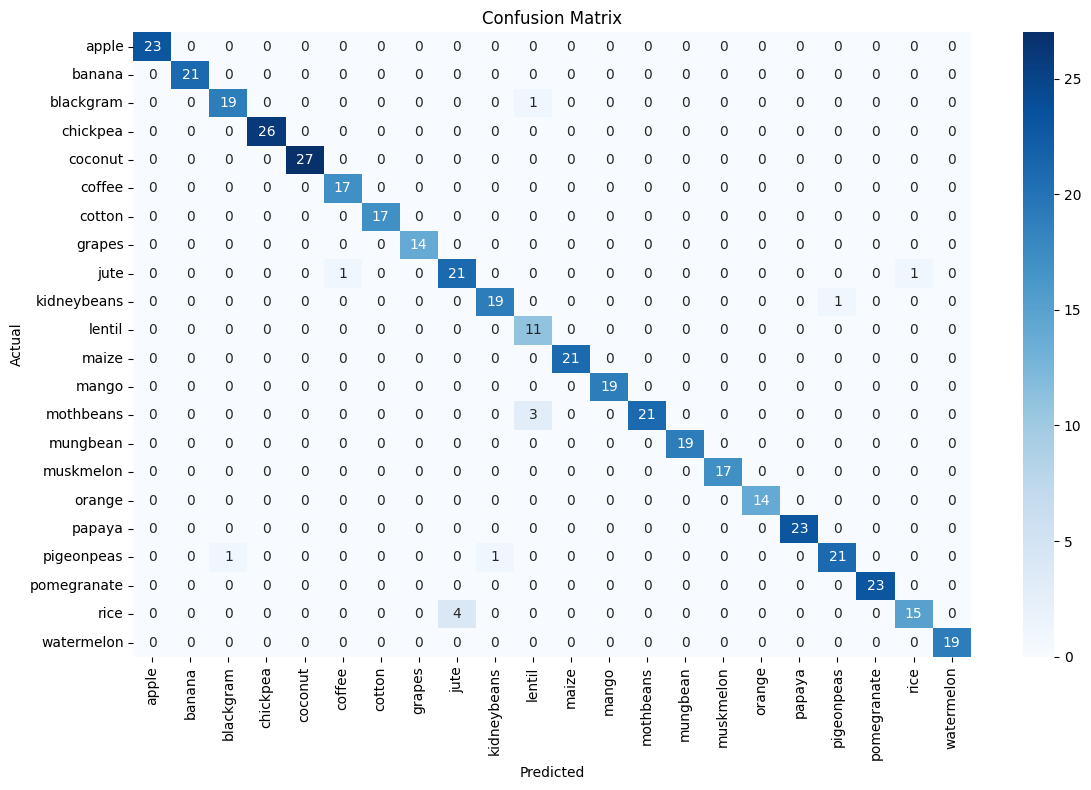

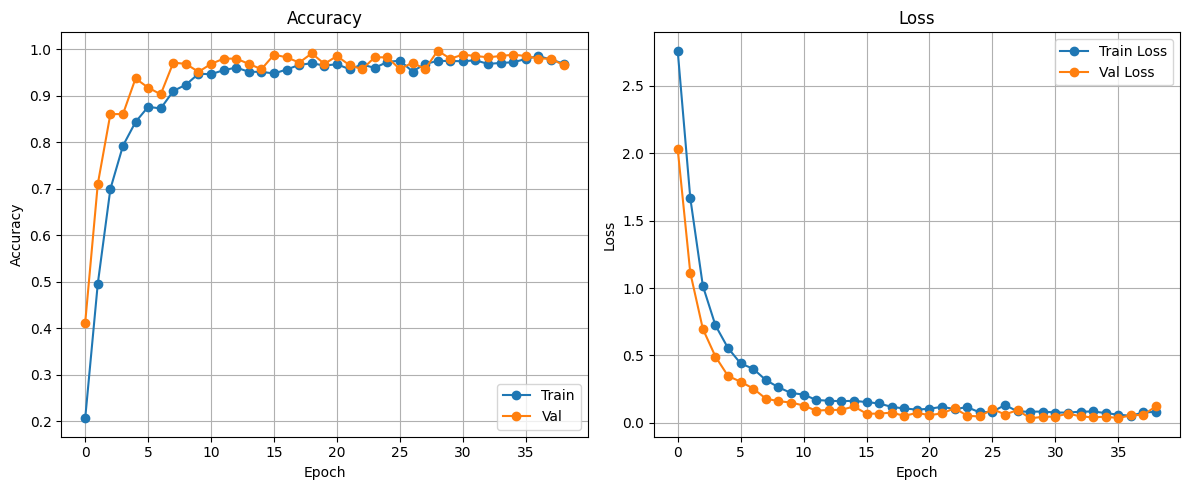

In [3]:
import pandas as pd
import numpy as np
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, GRU, LSTM, Dropout, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load and preprocess
df = pd.read_csv('/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv')
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = df[features].values
y = df['label'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq = X_scaled.reshape((X_scaled.shape[0], 7, 1))  # (samples, features, 1)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

# TabTransformer: Self-attention across feature tokens
def tabtransformer(input_dim, num_features, num_classes, d_model=32, num_heads=4, ff_dim=64):
    inp = Input(shape=(num_features,))

    # Each feature projected into embedding space
    x = Dense(d_model)(inp)
    x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x)

    # Transformer block
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = Add()([x, attn])
    x = LayerNormalization()(x)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(d_model)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=inp, outputs=out)

model = tabtransformer(input_dim=7, num_features=7, num_classes=y_cat.shape[1])  # or crosstransformer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stop], verbose=1)

loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 5. Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 6. Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Val', marker='o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

